In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
#from hippylib import nb
import nb as nb

# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False

import matplotlib.pyplot as plt
import cyipopt

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

In [3]:
def csr_fenics2scipy(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    #A_scipy.eliminate_zeros()
    return A_scipy

class Boundary(dl.SubDomain):
    def inside(me, x, on_boundary):
        return on_boundary

    
"""
An object which will internally handle the finite-element
discretization of the infinite-dimensional inverse problem
and set up the linear KKT system.
"""    

class inverseDiffusion:
    def __init__(me, Vh, beta, gamma, gamma1, ud, f):
        
        me.Vh    = Vh
        # size of operator
        me.n     = me.Vh.dim()
        # first idx indices correspond to state others to parameter
        me.idx   = me.Vh.sub(0).dim()
        # data that we are fitting the model to
        me.ud    = ud
        # rhs
        me.f = f
        
        me.beta   = beta
        me.gamma  = gamma
        me.gamma1 = gamma1
        utest, mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        Rform        = dl.Constant(gamma) * mtest * mtrial * dl.dx(me.Vh.mesh())
        Mform        = (utest * utrial + mtest * mtrial) * dl.dx(me.Vh.mesh())
       
        me.R_fenics  = dl.assemble(Rform)
        me.R         = csr_fenics2scipy(me.R_fenics)[me.idx:, me.idx:]
        me.M_fenics  = dl.assemble(Mform)
        me.Mx        = csr_fenics2scipy(me.M_fenics)
        me.Mu        = me.Mx[:me.idx,:me.idx]
        me.Mm        = me.Mx[me.idx:,me.idx:]        
        me.x         = dl.Function(me.Vh)
    """
    In what follows x will be a function on the state-parameter product
    finite-element space
    """
    
    """
    objective -- return the value of the regularized data-misfit functional at x
    """
    def objective(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        return dl.assemble((dl.Constant(0.5) * (X.sub(0)-me.ud)**2. + \
                           dl.Constant(me.gamma/2.)*X.sub(1)*X.sub(1) + \
                           dl.Constant(me.gamma1/2.)*dl.inner(\
                           dl.grad(X.sub(1)), dl.grad(X.sub(1))))*dl.dx(me.Vh.mesh()))
    """
    gradient -- return the variational derivative of J with respect to x
    """
    def gradient(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        utest, mtest = dl.TestFunctions(me.Vh)
        return dl.assemble(((X.sub(0) - me.ud) * utest + \
                            dl.Constant(me.gamma) * X.sub(1) * mtest + \
                            dl.Constant(me.gamma1) * \
                            dl.inner(dl.grad(X.sub(1)), dl.grad(mtest)))*dl.dx(me.Vh.mesh())).get_local()
    """ 
    return the second variational derivative of J with respect to x, that is 
    a linear mapping from primal to dual 
    """
    def DxxJ(me, x):
        utest, mtest = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return csr_fenics2scipy(dl.assemble((utrial*utest + \
                                dl.Constant(me.gamma)*\
                                mtrial*mtest + \
                                dl.Constant(me.gamma1)*\
                                dl.inner(dl.grad(mtest), dl.grad(mtrial)))*dl.dx(me.Vh.mesh()))).todense()
    """
    constraints -- evaluate the PDE-constraint at x, returning a dual-vector 
    """    
    def constraints(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        utest, mtest = dl.TestFunctions(me.Vh)
        return dl.assemble((X.sub(1)*dl.inner(dl.grad(X.sub(0)), dl.grad(utest)) + \
                            dl.Constant(me.beta)*X.sub(0)*utest - me.f*utest)*dl.dx(me.Vh.mesh()))\
                            .get_local()[:me.idx]
    """
    evaluate the variational derivative of the PDE-constraint with respect
    to x, 
    return a linear mapping from the primal to the dual
    """
    def jacobian(me, x):
        X = dl.Function(me.Vh)
        X.vector().set_local(x)
        utest, mtest   = dl.TestFunctions(me.Vh)
        p, _ = dl.TrialFunctions(me.Vh)
        return csr_fenics2scipy(\
                   dl.assemble((X.sub(1)*dl.inner(dl.grad(utest), dl.grad(p)) + \
                                mtest*dl.inner(dl.grad(X.sub(0)), dl.grad(p))+ me.beta*utest*p)*\
                               dl.dx(me.Vh.mesh())))[:,:me.idx].todense().T
    def Dxxcp(me, x, p):
        X = dl.Function(me.Vh)
        P = dl.Function(me.Vh)
        P.vector().vec()[:me.idx] = p[:]
        X.vector().set_local(x)
        utest, mtest   = dl.TestFunctions(me.Vh)
        utrial, mtrial = dl.TrialFunctions(me.Vh)
        return csr_fenics2scipy(dl.assemble((mtest * dl.inner(dl.grad(utrial), dl.grad(P.sub(0))) + \
                                             mtrial * dl.inner(dl.grad(utest), dl.grad(P.sub(0))))*\
                                            dl.dx(me.Vh.mesh()))).todense()
    def hessian(me, x, p, obj_fac):
        H = obj_fac * me.DxxJ(x) + me.Dxxcp(x, p)
        return H
    def intermediate(
            self,
            alg_mod,
            iter_count,
            obj_value,
            inf_pr,
            inf_du,
            mu,
            d_norm,
            regularization_size,
            alpha_du,
            alpha_pr,
            ls_trials
            ):

        #
        # Example for the use of the intermediate callback.
        #
        print("Barrier parameter value at iteration #%d is - %g" % (iter_count, mu))
        print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

# Define the mesh.

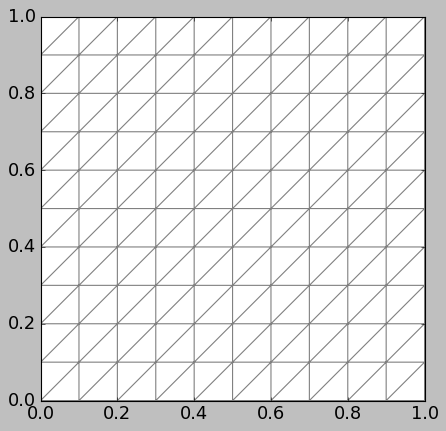

In [4]:
nx = 10

mesh = dl.UnitSquareMesh(nx, nx)
dl.plot(mesh)
plt.show()

Form the discretized state/parameter product finite-element space. With this one can determine all sub-blocks of the KKT linear system which are discretization of (mixed) sparse finite element matrices.

# Define finite element spaces over the mesh. 

In [5]:
P1 = dl.FiniteElement("CG", mesh.ufl_cell(), 1)
P2 = dl.FiniteElement("CG", mesh.ufl_cell(), 2)
Th = dl.MixedElement([P2, P1])
Vh = dl.FunctionSpace(mesh, Th)
Vh1 = dl.FunctionSpace(mesh, P1)
Vh2 = dl.FunctionSpace(mesh, P2)

In [6]:
beta   = 1.e-4
gamma  = 1.e-4
gamma1 = 1.e-4
ml  = dl.interpolate(dl.Expression('0.75', element=Vh1.ufl_element()), Vh1)
ud  = dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                      pi=np.pi, element=Vh2.ufl_element()), Vh2)
f   = dl.interpolate(dl.Expression('(2.*pi*pi*(0.5+x[0]) + beta)*std::cos(x[0]*pi)*std::cos(x[1]*pi)'+\
                                      '+pi*std::sin(pi*x[0])*std::cos(pi*x[1])',\
                                       pi=np.pi, beta=beta, element=Vh2.ufl_element()), Vh2)

mtrue = dl.interpolate(dl.Expression('0.5+x[0]',\
                                     element=Vh1.ufl_element()), Vh1)

In [7]:
inverse = inverseDiffusion(Vh, beta, gamma, gamma1, ud, f)

# initial point
x0 = [0. if i < Vh2.dim() else (1.0 + ml.vector()[i-Vh2.dim()]) for i in range(Vh.dim())]

# lower and upper bound constraints
lb = [-2.0e19 if i < Vh2.dim() else ml.vector()[i-Vh2.dim()] for i in range(Vh.dim())]
ub = [2.0e19 for i in range(Vh.dim())]

# constraint lower and upper bounds
cl = [0. for _ in range(Vh2.dim())]
cu = [0. for _ in range(Vh2.dim())]

nlp = cyipopt.Problem(n=Vh.dim(), m=Vh2.dim(), problem_obj=inverse, lb=lb, ub=ub, cl=cl,cu=cu)

#nlp.add_option('mu_strategy', 'adaptive')
nlp.add_option('tol', 1.e-6)
nlp.add_option('max_iter', 100)
#nlp.add_option('derivative_test', 'first-order')
x, info = nlp.solve(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:   247842
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   158203

Total number of variables............................:      562
                     variables with only lower bounds:      121
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      441
Total number of inequality co

  36  1.6522174e-03 1.15e-04 1.80e-04  -5.7 4.72e-02  -2.4 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #37 is - 1.84491e-06
Objective value at iteration #37 is - 0.00160873
  37  1.6087267e-03 8.79e-06 1.64e-04  -5.7 1.53e-02  -2.0 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #38 is - 1.84491e-06
Objective value at iteration #38 is - 0.00150698
  38  1.5069756e-03 7.61e-05 1.63e-04  -5.7 5.03e-02  -2.4 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #39 is - 1.84491e-06
Objective value at iteration #39 is - 0.00147108
  39  1.4710821e-03 6.92e-06 1.45e-04  -5.7 1.53e-02  -2.0 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #40 is - 1.84491e-06
Objective value at iteration #40 is - 0.00138389
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3838887e-03 8.98e-05 1.40e-04  -5.7 5.66e-02  -2.5 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #41 is - 1.84491e-06
Objective value at iteration

  78  6.8072468e-04 5.56e-05 7.64e-05  -5.7 6.46e-02  -2.6 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #79 is - 1.84491e-06
Objective value at iteration #79 is - 0.000672163
  79  6.7216268e-04 1.39e-06 7.10e-05  -5.7 8.79e-03  -2.1 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #80 is - 1.84491e-06
Objective value at iteration #80 is - 0.000668946
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  6.6894638e-04 2.11e-07 7.07e-05  -5.7 3.48e-03  -1.7 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #81 is - 1.84491e-06
Objective value at iteration #81 is - 0.00066094
  81  6.6093950e-04 1.63e-06 7.03e-05  -5.7 1.01e-02  -2.2 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #82 is - 1.84491e-06
Objective value at iteration #82 is - 0.000657685
  82  6.5768471e-04 2.62e-07 6.97e-05  -5.7 3.87e-03  -1.8 1.00e+00 1.00e+00h  1
Barrier parameter value at iteration #83 is - 1.84491e-06
Objective value at iterat

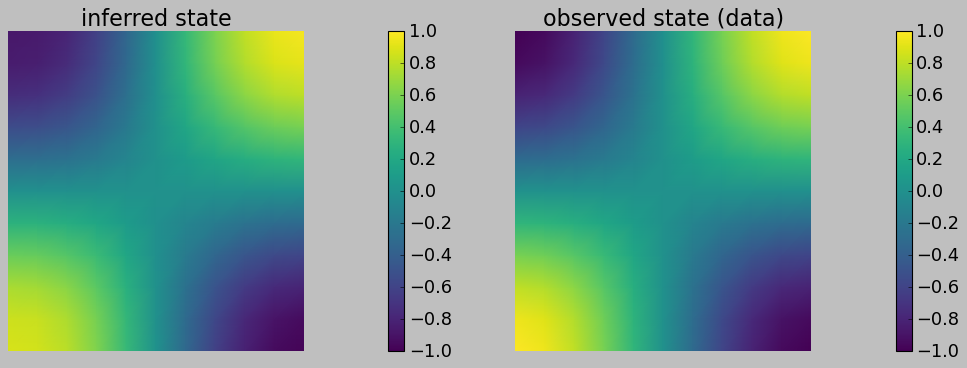

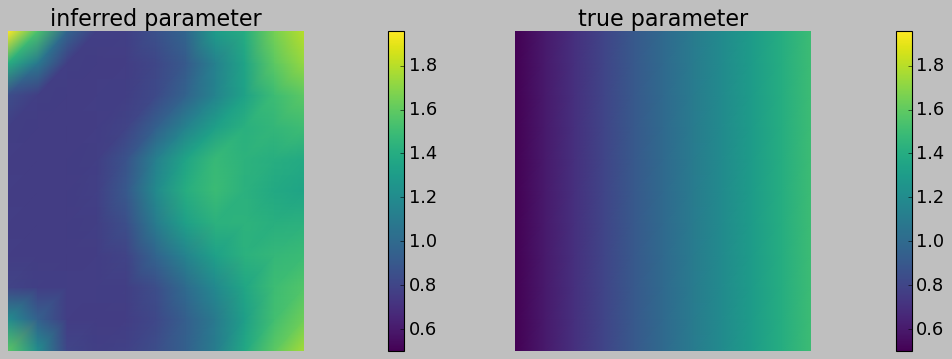

constraint violation =  4.0271931686222956e-06


In [8]:
X = dl.Function(Vh)
X.vector().set_local(x)
nb.multi1_plot([X.sub(0, deepcopy=True), ud], ["inferred state", "observed state (data)"])
plt.show()

nb.multi1_plot([X.sub(1, deepcopy=True), mtrue], ["inferred parameter", "true parameter"])
plt.show()

print("constraint violation = ", np.linalg.norm(inverse.constraints(x)))


### With given parameter, solve the state equation exactly and see how well the state compares to the data

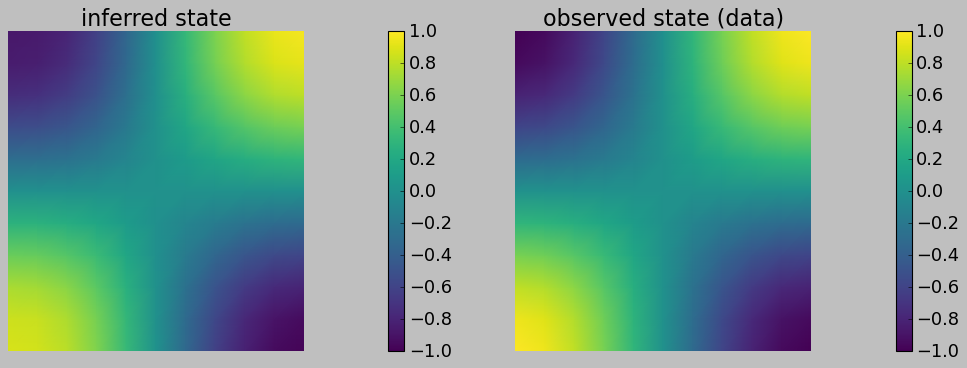

In [9]:


utest = dl.TestFunction(Vh2)
utrial = dl.TrialFunction(Vh2)
a = (X.sub(1)*dl.inner(dl.grad(utest), dl.grad(utrial)) + beta * utest * utrial)*dl.dx(Vh.mesh())
L = f * utest * dl.dx(Vh.mesh())
A, b = dl.assemble_system(a, L, [])
u = dl.Function(Vh2)
dl.solve(A, u.vector(), b)

nb.multi1_plot([u, ud], ["inferred state", "observed state (data)"])
plt.show()